#Data Loading

In [3]:
#TODO refactorer pour que chaque segment soit le plus indépendant possible)
#I should use the CPU-time to show variations, because all nodes dont have the same processor frequency...
#attention a la définition de doublons quand on intégrerea les variantes d'ordre, il faudra redféfinir lidagg d'un pb...
#toujours vérifier ce qu'on droppe en affichant exhaustivement les colonnes
%matplotlib inline
import pandas as pd
import numpy as np#do not use inplace = True !! unstable behaviour between slices, views, chains indexing etc...
import csv
import matplotlib.pylab as plt
import os
def readAll(path, problemFilename):
    '''merge all files whose name contains filename in the dir path'''
    frames=[]
    for filename in os.listdir(path) :
        if not problemFilename in filename:
            continue
        dftemp = pd.read_csv(path+filename, header=0,sep = ',|;',engine = 'python')  
        frames.append(dftemp)
    return pd.concat(frames,ignore_index=True)    

#path = '/home/magma/BIO_mono_multi_debrief/tempstats/'
path = '/home/magma/BIO_mono_multi_debrief/stats/newstats/'

generatedProblems = 'generated_MONO_problems.csv'
finishingProblems = 'finishing_MONO_problems.csv'
failedProblems = 'failed_MONO_problems.csv'
multiProblems = 'running_stats_MULTI_problems' 
  
dfGen =readAll(path,generatedProblems)#check nb of problems  : too many
dfFin =readAll(path,finishingProblems)       
dfFail=readAll(path,failedProblems)  
dfMulti=readAll(path, multiProblems) #on n'a pas fait tourner le agent 8 a fond pour tout : 
#comme aucun ne finissait sous 10mn  

print 'nb de Pb mono ne faisant pas de time out',len(dfFin.index)
print 'nb de Pb Mono faisant un timeout ou échouant',len(dfFail.index)
print 'nb de Pb Multi total', len(dfMulti.index)
print 'nb de Pb Multi faisant un timeout', len(dfMulti[dfMulti['timed_out']==1])

nb de Pb mono ne faisant pas de time out 2717
nb de Pb Mono faisant un timeout ou échouant 725
nb de Pb Multi total 12144
nb de Pb Multi faisant un timeout 7773


#Data Munging 
columns extraction, renaming, dropping incomplete data ...

In [4]:
def splitTokenMeth(df):
    df['tokenorder'] = np.nan
    df.loc[df['method'].str.contains("Token"),'tokenorder'] = df.loc[df['method'].str.contains("Token"),'method'].replace(to_replace=r'DICF-PB-Token-FixedOrder-', value=r"",regex=True)
    df.loc[df['method'].str.contains("Token"),'method']= 'DICF-PB-Token'
def renameParamsOr(df):
    #df.columns = df.columns.str.replace('or_','')
    #columnsD = {'or_method' : 'method', 'or_numagent' : 'numagent', 'or_csq' : 'csq','or_dist':'dist'}
    #df.rename(columns=columnsD, inplace= True)   
    df['method'] = df['or_method']
    df['numagent'] = df['or_numagent']
    df['csq'] = df['or_csq']
    df['dist'] = df['or_dist']
    df['csq_mono']=df['or_csq_mono']
    
def addParameters(dfMulti):
    # on ajoute les paramètres de distribution trouvés dans le filename
    #ici par exemple
    dfMulti['lengthvar'] = dfMulti['var']
    dfMulti['lengthvar'].replace(to_replace=r'\w+(-\d+)?_ld([\d-]+)--1', value=r"\2",inplace=True,regex=True) 
    print dfMulti[['var','lengthvar']].head(2)
    dfMulti['lengthvar']=dfMulti['lengthvar'].convert_objects(convert_numeric = True)
    
    #moyen un peu compliqué mais bon ca marche...
    dfMulti['propvar'] = np.nan
    #s = dfMulti.loc[~dfMulti['var'].str.contains("all")].loc[:,'propvar']
    #s = dfMulti.loc[~dfMulti['var'].str.contains("all")].replace(to_replace=r'\w+(-(\d+))?_ld([\d-]+)--1', value=r"\2",regex=True) 
    dfMulti.loc[~dfMulti['var'].str.contains("all"),'propvar']=dfMulti.loc[~dfMulti['var'].str.contains("all"),'var'].replace(to_replace=r'\w+(-(\d+))?_ld([\d-]+)--1', value=r"\2",regex=True)
    print dfMulti[['var','propvar']].head()
    dfMulti['propvar']=dfMulti['propvar'].convert_objects(convert_numeric = True)
    
    dfMulti['total time mn'] = dfMulti['total time']/60./1000.
    #glucolysis
    #_TPnaiveshortdist_per10_seuil1
    #_kmet6_TPuniformshortdist_per10_seuil1
    #glucolysis_naiveEq4_TPuniformshortdist_per1_seuil1
    
    dfMulti['methodvar'] = dfMulti['var'].replace(to_replace=r".(...).*", value=r"\1", regex= True )
    print dfMulti['methodvar'].head()
    
    
    #pbBase
    dfMulti['pbbase'] = dfMulti['infile'].replace(to_replace = r'_.*',value ='',regex=True)
    print dfMulti[['infile', 'pbbase']].head()
    
    #prepartition
    dfMulti['isprepar'] = 0
    print dfMulti['isprepar'].head()    
    dfMulti.loc[dfMulti['infile'].str.contains(r'_kmet|_naiveEq', regex=True),'isprepar'] = 1
    print len(dfMulti)
    print dfMulti.loc[dfMulti['isprepar'] == 1,'isprepar'].sum()
    print len(dfMulti.loc[dfMulti['isprepar'] == 1].index)
    print dfMulti.loc[dfMulti['isprepar'] == 0,'isprepar'].sum()
    
    #type de prepartition
    dfMulti['prepar'] = np.nan
    dfMulti.loc[dfMulti['infile'].str.contains(r'_kmet', regex=True),'prepar'] = 'kmet'
    dfMulti.loc[dfMulti['infile'].str.contains(r'_naiveEq', regex=True),'prepar'] = 'naiveEq'
    
    #percentage de distribution
    #regex= r"\w*_TPuniformshortdist_per(|\d+)_seuil\w*|\w*TPnaiveshortdist_per(|\d+)_seuil\w*"
    regexPreD = r"\w*_TPuniformshortdist_per(\d+)_seuil\w*"
    regexNPreD = r"\w*TPnaiveshortdist_per(\d+)_seuil\w*"
    dfMulti['propTP']= 0.3#c'est le nb approximé de Top clause de glucolysis (il y en a  un)
    print dfMulti[['infile', 'propTP']].head(5)
    #dfMulti.loc[dfMulti['infile'].str.contains('TPuniformshortdist'),'propTP'].replace(to_replace = regexPreD ,value =r"\1",inplace=True,regex=True)
    #dfMulti.loc[dfMulti['propTP'].str.contains('TPnaiveshortdist'),'propTP'].replace(to_replace = regexNPreD ,value =r"\1",inplace=True,regex=True)
    
    dfMulti.loc[dfMulti['infile'].str.contains('TPuniformshortdist'),'propTP']=dfMulti.loc[dfMulti['infile'].str.contains('TPuniformshortdist'),'infile'].replace(to_replace = regexPreD ,value =r"\1",regex=True)
    dfMulti.loc[dfMulti['infile'].str.contains('TPnaiveshortdist'),'propTP']=dfMulti.loc[dfMulti['infile'].str.contains('TPnaiveshortdist'),'infile'].replace(to_replace = regexNPreD ,value =r"\1",regex=True)
    dfMulti['propTP'] = dfMulti['propTP'].convert_objects(convert_numeric = True)
    #unmatched group error
    #dfMulti.loc[:,'propTP']=dfMulti['propTP'].replace(to_replace = regex ,value =r"\1\2",regex=True)
    print dfMulti[['infile', 'propTP']].head(5)
    
def drop_values (valuesToDrop, df):
    '''
    if contains (not strict equality here...)
    '''
    new_df = df
    for columnName in list(df.columns.values) :
        for v in valuesToDrop :
            if v in columnName :    
                print 'dropping :',columnName,'::',v 
                df.drop([columnName],axis = 1, inplace=True)
                break
#methode alternative    
def replace_meth(x):
    method=x['method']
    if 'DICF-PB-Async' in method or 'DICF-PB-Star' in method :
        return method
    elif 'Token' in method :
        return 'DICF-PB-Token'
    else :
        return method    
def splitParams(df):
    #create new filed and assign previous agg value and then apply replacw fun on it
    df['method']=df.apply(replace_meth, axis=1)

#RAJOUTER LES PARAMETRES = A ÉTÉ DISTRIBUÉ ETC... EN SPLITANT LE FILENAME, METTRE DES 
#ici on enlève le slignes qui ont au moins une valeur nan, ICI IL N, Y EN A PAS 


#MONO
dfFin['total time mn'] = dfFin['total time']/60./1000.

#MULTI
nbRows = len(dfMulti.index)
nbCol = len(dfMulti.columns)
res = dfMulti.dropna(how='any')
print (nbRows - len(dfMulti.index)), ' lignes nulles ont été enlevées'

renameParamsOr(dfMulti)
splitTokenMeth(dfMulti)
addParameters(dfMulti)
print dfMulti['tokenorder'].head(4)
print dfMulti['method'].head(4)
print np.unique(dfMulti['root'].values)
valuesToDrop = ['max', 'sent','root', 'CPU','Cl']#, 'csq']
#drop_values (valuesToDrop, dfMulti)

#splitParams(dfMulti)
print dfMulti.columns



0  lignes nulles ont été enlevées
             var lengthvar
0  _max-3_ld1--1         1
1  _max-3_ld1--1         1
             var propvar
0  _max-3_ld1--1       3
1  _max-3_ld1--1       3
2  _max-3_ld1--1       3
3  _max-4_ld1--1       4
4  _max-4_ld1--1       4
0    max
1    max
2    max
3    max
4    max
Name: methodvar, dtype: object
                                    infile      pbbase
0  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
1  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
2  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
3  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
4  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
0    0
1    0
2    0
3    0
4    0
Name: isprepar, dtype: int64
12144
5599
5599
0
                                    infile  propTP
0  glucolysis_TPnaiveshortdist_per1_seuil1     0.3
1  glucolysis_TPnaiveshortdist_per1_seuil1     0.3
2  glucolysis_TPnaiveshortdist_per1_seuil1     0.3
3  glucolysis_TPnaiveshortdist_per1_seuil1 

#Visualize duplicates
& drop

il y a  0  doublons enlevés
ex de doublon :                                                 infile         method  \
10491  glucolysis_kmet6_TPuniformshortdist_per1_seuil1  DICF-PB-Async   

               var    dist  numagent  
10491  _all_ld4--1  _kmet6         6  
Int64Index([ 9970, 21341, 19522,  9749,  9737,  9963, 21573, 21577, 19521,
            19529, 
            ...
            21348,  7924,  7700,  9742, 11838, 21576, 21343, 19516,  9740,
            19291],
           dtype='int64', length=144)
anomalies en mn au dessus de  0.5 :  []


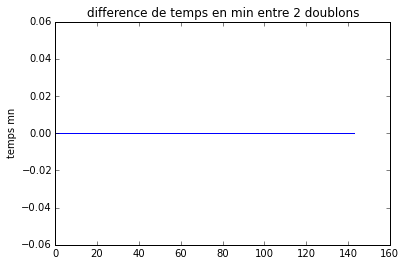

In [6]:
import math
def gettimes(df,doublons,i):
    df_clear = df[['infile', 'method', 'var', 'csq', 'dist', 'numagent','total time']]
    d1 = doublons[['infile', 'method', 'var', 'csq', 'dist', 'numagent']].loc[i]
  
    df_doublons= df_clear[d1 == df_clear ]
    df_doublons['total time'] = df_clear['total time']
    df_end = df_doublons.dropna(thresh=7) 
    if len(df_end.index)>1 :
        #print df_end[['infile', 'method', 'var', 'csq', 'dist', 'numagent','total time']].iloc[:2]
        return df_end['total time'].iloc[0],df_end['total time'].iloc[1]
    else:
        return 0,0

def show_duplicates(df, idset):
    '''
    subset are the colums identifying a problem, (all but measures)
    
    see if indexing plays a part in it...
    '''
    
    nbOr= len(df.index)
    df_deduplicated = df.drop_duplicates(subset = idset ,take_last = True)
    nbDest= len(df_deduplicated.index)
    print 'il y a ', nbOr - nbDest, ' doublons enlevés'
    
    df_cat = pd.concat([df, df_deduplicated])
    df_cat = df_cat.reset_index(drop=True)
    
    df_gpby = df_cat.groupby(list(df_cat.columns))
    df_gpby.groups.values()
    
    #on prend les index des problèmes qui ne sont pas en double : qui ont été droppés
    idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]
    doublons = df_cat.reindex(idx)
    
    #test pour récupérer le premier doublon de la liste
    df_clear = df[['infile', 'method', 'var', 'csq', 'dist', 'numagent','total time']]
    d1 = doublons[['infile', 'method', 'var', 'csq', 'dist', 'numagent']].iloc[0]
  
    df_doublons= df_clear[d1 == df_clear ]
    df_doublons['total time'] = df_clear['total time']
    df_end = df_doublons.dropna(thresh=7) 
    print 'ex de doublon :',df_end[['infile', 'method', 'var', 'dist', 'numagent']]
    
    #on récupère le temps d'exéc des doublons pour les comparer
    size = len(doublons.index)
    print doublons.index
    
    values = [gettimes(df,doublons,i) for i in doublons.index]
    y1 = [(v[0] - v[1])/60./1000. for v in values]
    
    thresh = 0.5
    anomalies =[(ind,v) for ind,v in enumerate(y1) if math.fabs(v) > thresh]
    xAnomalies = [ind for ind, v in anomalies]
    print 'anomalies en mn au dessus de ',thresh,': ',anomalies 
    plt.plot(y1)    
    plt.title('difference de temps en min entre 2 doublons')
    plt.ylabel('temps mn')
    plt.show()
idset = ['infile', 'method', 'var', 'csq', 'dist', 'numagent','problem']
show_duplicates(dfMulti,idset)
dfMulti = dfMulti.drop_duplicates(subset = idset ,take_last = True)

on voit que c'est négligeable, bien que les données soient très limoitées (400 doublons seulement) on peut être rassuré sur les conditions d'expériences qui sont à peu près les mêmes (pour que ce soit strict il faudrait faire les exériences sur toujours les mêmes machines)

#Export Data As Now
here we export the whole data for analysis in another framework


In [5]:
dfMulti.to_csv('MERGED_'+multiProblems+'.csv', index = False)
dfFin.to_csv('MERGED_'+finishingProblems+'.csv',index = False)

#Basic Stats

In [4]:
def printInfoOnDf(df):
    print df.describe()
    print 'number of rows',len(df.index)
    print 'number of column',len(df.columns.values)
    print df.columns.values
printInfoOnDf(dfFin)
printInfoOnDf(dfMulti)


       timeout     numagent  max CPU time by SOLAR  min consequences sent  \
count     2717  2374.000000            2717.000000                   2717   
mean   2000000     4.906487           39262.775488                      0   
std          0     2.195774           76295.847216                      0   
min    2000000     2.000000            1764.000000                      0   
25%    2000000     2.000000            6021.000000                      0   
50%    2000000     4.000000           11259.000000                      0   
75%    2000000     6.000000           34662.000000                      0   
max    2000000     8.000000          833951.000000                      0   

       nbAg+  root-extensions  min CPU time by SOLAR  min total size messages  \
count   2717     2.717000e+03            2717.000000                     2717   
mean       1     1.187889e+07           39262.775488                        0   
std        0     1.887542e+07           76295.847216           

#Filter problems
here we want the Multi problems corresponding to the mono problems which finish under a certain timelimit
(since the timeout is not the same in both cases...)

In [7]:
def getProblemsUnderTime(df, time):
    '''
    get problems having finished under xxxxxx ms
    '''
    return df[df['total time'] < time]
def aggregate(df):
    '''on aggrege une sorte d id du probleme parce que sinon ca devient trop verbose et pandas deconne...'''
    df['indagg'] = df['infile_path']+ df['infile'] + df['var'] # +df['dist']
    
def filterPb(dfOrig, df,timelimit) :
    '''
    we wish to keep only the multi problems whos corresponding mono problem finishes below 10 minutes
    '''
    nbPbO=len(dfOrig.index)
    nbPbD =len(df.index)
    
    aggregate(df)#agg est une sorte d'id de problem
    aggregate(dfOrig)
    dfOrig = dfOrig[dfOrig['total time'] < timelimit]
    #print df['method'].str.contains("Token")
    df['underT'] = 0
    df.loc[df['indagg'].isin(dfOrig['indagg']), 'underT'] = 1
  
    res = df.loc[df['underT']==1]
    
    
    print len(df.index)
    print len(df[df['underT']==1])
    print len(df[df['underT']==0])
     
    print 'nb de Pb Mono Originaux',nbPbO
    print 'nb de Pb Multi Originaux',len(df.index)
    print 'nb de Pb mono Originaux < time limit = ',timelimit,' : ',len(dfOrig.index)
    print 'prop gardée',len(dfOrig.index) / float(nbPbO)    
    print 'nb de Pb multi Originaux < time limit = ',timelimit,' : ',len(res.index)
    print 'prop gardée',len(res.index) / float(nbPbD)

    return res
dfMulti_filt = filterPb(dfFin, dfMulti,600000)

11603
9074
2529
nb de Pb Mono Originaux 2717
nb de Pb Multi Originaux 11603
nb de Pb mono Originaux < time limit =  600000  :  2279
prop gardée 0.838792786161
nb de Pb multi Originaux < time limit =  600000  :  9074
prop gardée 0.782039127812


#Temps d'exécution
pour mono le timeout par défaut est 2000000 ms soit 33.3 mn
###Mono/Multi

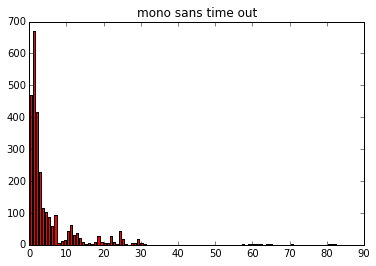

Il y a  20 problèmes qui dépassent la limite de  2000000 ms


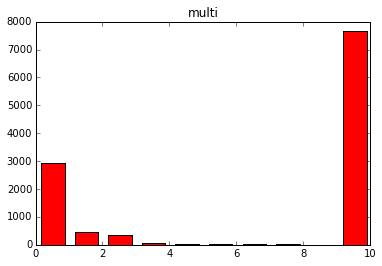

Il y a  0 problèmes qui dépassent la limite de  605000 ms


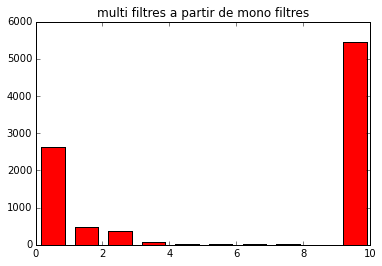

Il y a  0 problèmes qui dépassent la limite de  605000 ms


In [6]:
def makeHistoTotalTime(df, limite, bins=30, title=''):
    df = df['total time']
    s= pd.Series(df, name ='total time')
    tooL = [el for el in s if el > limite]
    a = pd.np.array(s)
    a = a/1000./60.   #convert into minutes
    
    hist, bins = np.histogram(a, bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width,color = 'r')
    plt.title(title)
    plt.show()
    print 'Il y a ', len(tooL), 'problèmes qui dépassent la limite de ',limite,'ms'
    
makeHistoTotalTime(dfFin,2000000,bins = 100, title='mono sans time out')
makeHistoTotalTime(dfMulti,605000,bins = 10,title='multi')
makeHistoTotalTime(dfMulti_filt,605000,bins = 10,title='multi filtres a partir de mono filtres')

on observe que le time out du mono agent n'est pas respecté, même s'il la très grande majorité des problèmes est en desssous de la valeur de 30 minutes, alors que le multi montre bien un seuil correspondant au timeout normal.

###By Agent & comparison when filtered

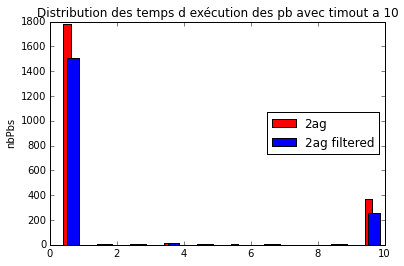

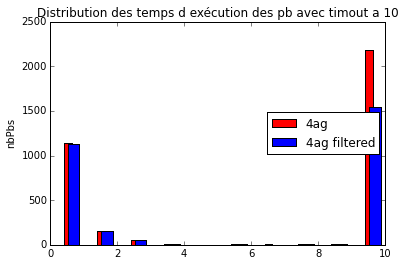

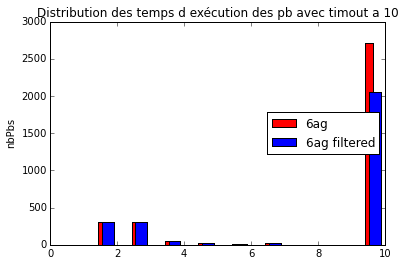

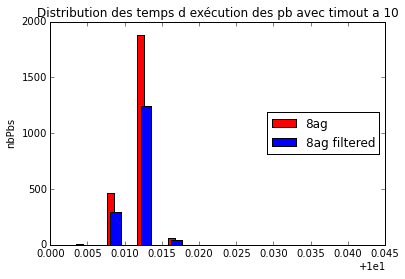

In [8]:
def plotDistAgents(dfMulti,bins = 10, lAgents = [2,4,6,8]):

    pbXAg = [dfMulti[dfMulti['numagent'] == i] for i in lAgents]#range(2,9,2)]
    timeXAg = [xAg['total time'] for xAg in pbXAg]
    timeSeriesXAg = [pd.np.array(pd.Series(df, name = 'total time')) for df in timeXAg]
    timeSeriesXAg = [ts/1000./60.for ts in timeSeriesXAg ]

    histbinsXAg = [np.histogram(a, bins = bins) for a in timeSeriesXAg]
    widthXAg = [ 0.7 * (bins[1] - bins[0]) for hist,bins in histbinsXAg]
    centerXAg = [(bins[:-1] + bins[1:]) / 2 for hist,bins in histbinsXAg]
    colorXag = ['r','b','y','g']
    pXAg=[]
    for i in range (len(pbXAg)):
        hist, bins = histbinsXAg[i]
        pXAg.append(plt.bar(centerXAg[i], hist,   width= widthXAg[i], color=colorXag[i]))

    plt.ylabel('nbPbs')
    plt.title(u'Distribution des temps d exécution des pb avec timout a 10')

    legends = ["".join([str(i),'ag'])for i in lAgents]
    pXAg = [p[0] for p in pXAg]
    plt.legend( pXAg, legends ,loc=7)
    plt.show()
    
def plotTwoDistAgents(dfMulti,dfMulti_filt,bins = 10, lAgents = [2,4,6,8]):
    pbXAg = [dfMulti[dfMulti['numagent'] == i] for i in lAgents]#range(2,9,2)]
    timeXAg = [xAg['total time'] for xAg in pbXAg]
    timeSeriesXAg = [pd.np.array(pd.Series(df, name = 'total time')) for df in timeXAg]
    timeSeriesXAg = [ts/1000./60.for ts in timeSeriesXAg ]

    histbinsXAg = [np.histogram(a, bins = bins) for a in timeSeriesXAg]
    widthXAg = [ 0.7 * (bins[1] - bins[0]) for hist,bins in histbinsXAg]
    centerXAg = [(bins[:-1] + bins[1:]) / 2 for hist,bins in histbinsXAg]
    colorXag = ['r','b','y','g']
    pXAg=[]
    for i in range (len(pbXAg)):
        hist, bins = histbinsXAg[i]
        pXAg.append(plt.bar(centerXAg[i], hist,   width= widthXAg[i]/3, color=colorXag[i], align = 'center'))

    
    legends = ["".join([str(i),'ag'])for i in lAgents]
    pXAgAx = [p[0] for p in pXAg]
    plt.legend( pXAgAx, legends ,loc=7)
    
    dfMulti = dfMulti_filt
    pbXAg = [dfMulti[dfMulti['numagent'] == i] for i in lAgents]#range(2,9,2)]
    timeXAg = [xAg['total time'] for xAg in pbXAg]
    timeSeriesXAg = [pd.np.array(pd.Series(df, name = 'total time')) for df in timeXAg]
    timeSeriesXAg = [ts/1000./60.for ts in timeSeriesXAg ]

    histbinsXAg = [np.histogram(a, bins = bins) for a in timeSeriesXAg]
    widthXAg = [ 0.7 * (bins[1] - bins[0]) for hist,bins in histbinsXAg]
    centerXAg = [(bins[:-1] + bins[1:]) / 2 for hist,bins in histbinsXAg]
    colorXag = ['b','r','g','y']
    #pXAg=[]
    for i in range (len(pbXAg)):
        hist, bins = histbinsXAg[i]
        pXAg.append(plt.bar(centerXAg[i], hist, width= widthXAg[i]/2, color=colorXag[i], align = 'edge'))

    plt.ylabel('nbPbs')
    plt.title(u'Distribution des temps d exécution des pb avec timout a 10')

    legends = legends + ["".join([str(i),'ag filtered'])for i in lAgents]
    pXAg = [p[0] for p in pXAg]
    plt.legend( pXAg, legends ,loc=7)

    plt.show()
plotTwoDistAgents(dfMulti,dfMulti_filt,bins=10, lAgents = [2])
plotTwoDistAgents(dfMulti,dfMulti_filt,bins=10, lAgents = [4])
plotTwoDistAgents(dfMulti,dfMulti_filt,bins=10, lAgents = [6])
plotTwoDistAgents(dfMulti,dfMulti_filt,bins=10, lAgents = [8])

                


on voit que le filtre permet d'éliminer en grande majorité de pb multi qui auraient timeout.
Donc qu'un problème complexe mono équivaut à un problème complexe multi

#Time out & nb Messages

###By method, number of agents, methodvar, prépartionnement

/home/magma/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


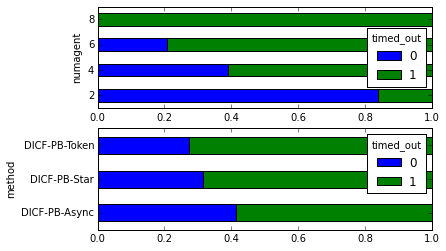

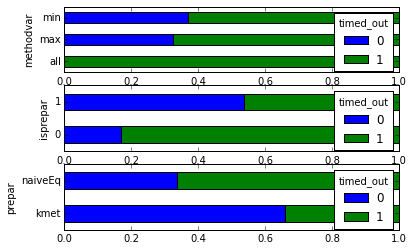

In [9]:
def proportionTimeOut(df,discreteVar):
    by_var = df.groupby([discreteVar,'timed_out']) #groups the data act on groups
       #seperately
    table = by_var.size() #gets group size counts, hashed by the two variables
    table = table.unstack() #splits the data into 2 columns, 0, 1, each indexed by the
    #other variable
    normedtable = table.div(table.sum(1), axis=0) #divides the counts by the totals
    return normedtable
def computeProp(df, discreteVarList=None):
    lenD = len(discreteVarList)
    fig1, axes1 = plt.subplots(lenD,1) 
    for i in range(lenD):
        var = discreteVarList[i]
        table = proportionTimeOut(df,var)
        table.plot(kind='barh', stacked=True, ax=axes1[i])
    fig1.show()
    
computeProp(dfMulti, discreteVarList = ['numagent','method'])
computeProp(dfMulti, discreteVarList = ['methodvar','isprepar', 'prepar'])


le isprepartitionné a l'air intéressant mais pour que l'analyse ait un sens, il faudrait ne les comparer qu'aux mêmes problèmes mais sans prépartionnement.
En tous cas il semble que le prépartitionnement kmetis ait de meilleurs effets qu en prenant les clauses contigues.
comparer le time out et le nb de messages, là ca pourrait être intéressant...^^

          mean nbMessages  mean timedout
numagent                                
2                6.783698            NaN
4               27.050112            NaN
6               45.447953            NaN
8               82.545342            NaN
2                     NaN       0.161658
4                     NaN       0.610022
6                     NaN       0.792398
8                     NaN       1.000000


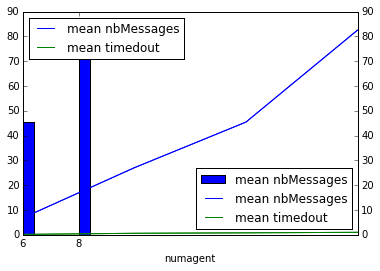

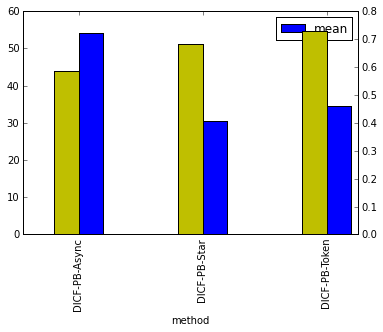

In [10]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

by_var = dfMulti.groupby(['numagent'])
s=by_var['nb Messages'].agg(['mean'])
d={'mean' : 'mean nbMessages'}
s = s.rename(columns=d)
a=s.plot(ax=ax,kind = 'bar',width = 0.2,position =0)

s2=by_var['timed_out'].agg(['mean'])
d2={'mean' : 'mean timedout'}
s2 = s2.rename(columns=d2)
s3 = pd.concat([s,s2])

print s3 
s3.plot(ax=ax2)
s3.plot(ax=ax)
#b2=s.plot(ax=ax2,kind = 'bar',color='y',width=0.2, secondary_y = True,position =1)


fig, ax = plt.subplots()
ax2 = ax.twinx()
by_var = dfMulti.groupby(['method'])
by_var['nb Messages'].agg(['mean']).plot(ax=ax,kind = 'bar',width = 0.2,position =0)
by_var['timed_out'].agg(['mean']).plot(ax=ax2,color='y',kind = 'bar',width=0.2, secondary_y = True,position =1, legend=False)


"\ns = by_var['timed_out'].agg(['mean'])\nprint s\nd={'mean' : 'mean timedout'}\ns = s.rename(columns=d)\nprint s\n#s.plot(ax=ax,kind = 'bar',width = 0.2,position =0)\n"

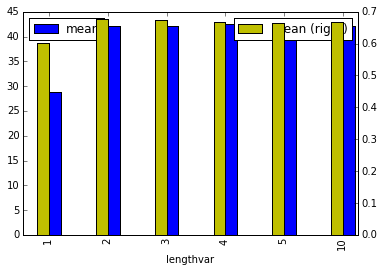

In [36]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
by_var = dfMulti.groupby(['lengthvar'])
by_var['nb Messages'].agg(['mean']).plot(ax=ax,kind = 'bar',width = 0.2,position =0, label ='eded')
by_var['timed_out'].agg(['mean']).plot(ax=ax2,color='y',kind = 'bar',width=0.2, secondary_y = True,position =1,label = 'efef')
"""
s = by_var['timed_out'].agg(['mean'])
print s
d={'mean' : 'mean timedout'}
s = s.rename(columns=d)
print s
#s.plot(ax=ax,kind = 'bar',width = 0.2,position =0)
"""

In [24]:
'''by_var = dfMulti.groupby(['numagent'])
by_var['nb Messages'].agg(['mean', 'std']).plot(kind = 'bar',title= 'nbMessages')
by_var['timed_out'].agg(['mean','std']).plot(kind = 'bar',title='timed_out')
'''

"by_var = dfMulti.groupby(['numagent'])\nby_var['nb Messages'].agg(['mean', 'std']).plot(kind = 'bar',title= 'nbMessages')\nby_var['timed_out'].agg(['mean','std']).plot(kind = 'bar',title='timed_out')\n"

In [25]:
dfPrepar = dfMulti[dfMulti['isprepar']==1]
dfNonPrepar = dfMulti[~dfMulti['isprepar']==1]
#df['indaggmulti'] = df['infile_path']+ df['infile'] + df['var'] +df['dist'] + df['numagent']+df['method']
#dfNonPrepar[dfNonPrepar.isin]

Int64Index([1, 2, 3, 4, 5, 10], dtype='int64', name=u'lengthvar')
[[ 28.84305949  21.11352437]
 [ 42.06197323  38.14470447]
 [ 42.22239032  38.44748818]
 [ 42.47058824  38.62251412]
 [ 42.20072239  38.24298667]
 [ 42.16452442  38.05402371]]
2222222
[ 1  2  3  4  5 10]
['1' '2' '3' '4' '5' '+inf']


TypeError: 'Text' object is not callable

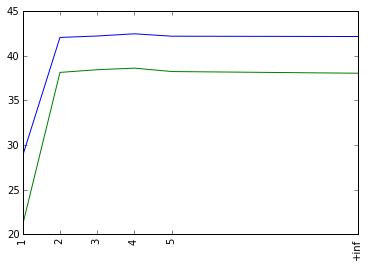

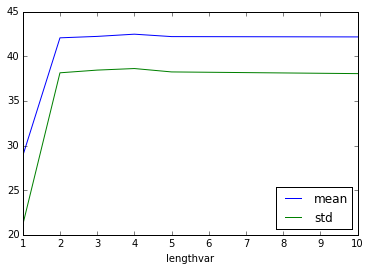

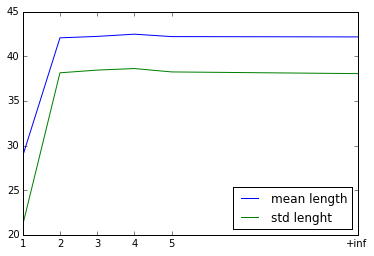

In [52]:
#ici 10 signifie sans limite...


dfMulti.loc[dfMulti['lengthvar'] == -1,'lengthvar']=10


grouped = dfMulti.groupby('lengthvar')
stats = ['mean','std']
result = grouped['nb Messages'].agg(stats)
print result.index
print result.values
labels = result.index.values
print  '2222222'
print labels
labels = np.concatenate((labels[:-1], np.array(['+inf'])))
print labels
plt.xticks(result.index.values, labels, rotation='vertical')
plt.plot(result.index.values, result.values, label ='ee>')
result.plot()
#

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

dfMulti.loc[dfMulti['lengthvar'] == -1,'lengthvar']=10
grouped = dfMulti.groupby('lengthvar')
stats = ['mean','std']
result = grouped['nb Messages'].agg(stats)
ax.set_xticks([1,2,3,4,5,10])
ax.set_xticklabels(labels)

#result.plot(ax=ax, label = 'deded')

ax.plot(result['mean'].index.values, result['mean'].values, label = 'mean length')

ax.plot(result['std'].index.values, result['std'].values, label = 'std lenght')
ax.legend(loc='best')
ax.title('title')


In [71]:
'''fig, ax = plt.subplots()
ax2 = ax.twinx()
#rspine = ax3.spines['right']
#rspine.set_position(('axes', 1.25))
#ax3.set_frame_on(True)
#ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)
a=result['mean'].plot(ax=ax,style='b-',label = 'mean')
b=result['std'].plot(ax=ax2, style = 'r-', secondary_y=True, label = 'std')

#result.plot( y = 'mean')
'''

"fig, ax = plt.subplots()\nax2 = ax.twinx()\n#rspine = ax3.spines['right']\n#rspine.set_position(('axes', 1.25))\n#ax3.set_frame_on(True)\n#ax3.patch.set_visible(False)\nfig.subplots_adjust(right=0.75)\na=result['mean'].plot(ax=ax,style='b-',label = 'mean')\nb=result['std'].plot(ax=ax2, style = 'r-', secondary_y=True, label = 'std')\n\n#result.plot( y = 'mean')\n"

,mean,std
propTP,,
0.3,0.624251,0.484497
1.0,0.659065,0.474114
2.0,0.594044,0.491172
5.0,0.671103,0.469913
10.0,0.730309,0.443880


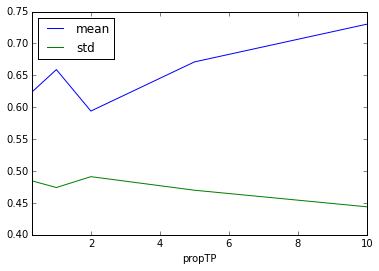

In [41]:
result = grouped['timed_out'].agg(stats)
result.plot()
result

,mean,count
propvar,,
1,40.995305,1065
2,42.004695,1065
3,41.430740,1054
4,42.589184,1054
5,42.198858,1051
10,42.962121,1056
15,35.223724,666


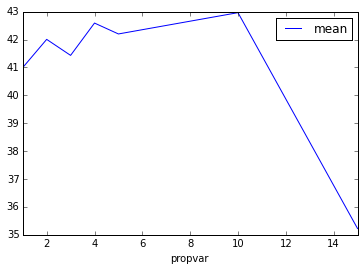

In [32]:
grouped = dfMulti[dfMulti['var'].str.contains("max")].groupby('propvar')
stats = ['mean','count']
result = grouped['nb Messages'].agg(stats)
result.plot( y = 'mean')
result


,mean,count
propvar,,
1,39.575435,1034
2,38.926736,1051
3,39.291498,988
4,38.956012,682
5,35.154856,381
10,34.791667,192
15,33.338542,192


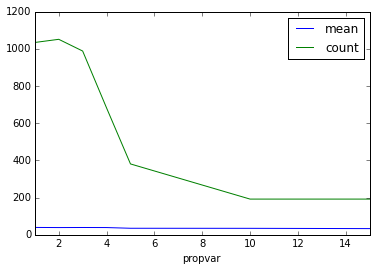

In [33]:
grouped = dfMulti[dfMulti['var'].str.contains("min")].groupby('propvar')
stats = ['mean','count']
result = grouped['nb Messages'].agg(stats)
result.plot()
result

,mean,std
lengthvar,,
-1,42.164524,38.054024
1,28.843059,21.113524
2,42.061973,38.144704
3,42.222390,38.447488
4,42.470588,38.622514
5,42.200722,38.242987


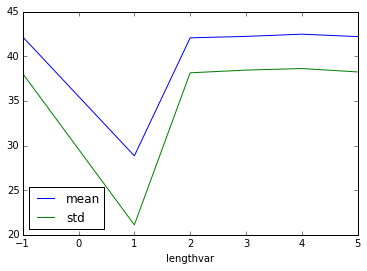

In [14]:
grouped = dfMulti.groupby('lengthvar')
stats = ['mean','std']
result2 = grouped['nb Messages'].agg(stats)
result2.plot()
result2

In [35]:
'''fig, ax = plt.subplots()
ax2 = ax.twinx()
#rspine = ax3.spines['right']
#rspine.set_position(('axes', 1.25))
#ax3.set_frame_on(True)
#ax3.patch.set_visiblezz(False)
fig.subplots_adjust(right=0.75)
a=result1['mean'].plot(ax=ax,style='b-',label = 'mean')
b=result2['mean'].plot(ax=ax2, style = 'r-', secondary_y=True, label = 'std')
'''

"fig, ax = plt.subplots()\nax2 = ax.twinx()\n#rspine = ax3.spines['right']\n#rspine.set_position(('axes', 1.25))\n#ax3.set_frame_on(True)\n#ax3.patch.set_visiblezz(False)\nfig.subplots_adjust(right=0.75)\na=result1['mean'].plot(ax=ax,style='b-',label = 'mean')\nb=result2['mean'].plot(ax=ax2, style = 'r-', secondary_y=True, label = 'std')\n"

,mean,std
propTP,,
0.3,45.706587,39.250821
1.0,45.036488,34.755488
2.0,39.666928,34.749690
5.0,35.416917,37.474953
10.0,37.396733,36.748974


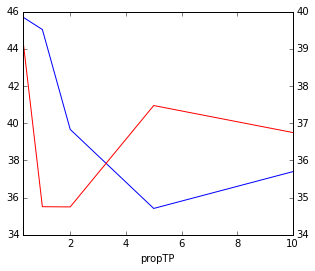

In [36]:
grouped = dfMulti.groupby('propTP')
stats = ['mean','std']
result = grouped['nb Messages'].agg(stats)
fig, ax = plt.subplots()
ax2 = ax.twinx()

fig.subplots_adjust(right=0.75)
a=result['mean'].plot(ax=ax,style='b-',label = 'mean')
b=result['std'].plot(ax=ax2, style = 'r-', secondary_y=True, label = 'std')
result


            mean       std
propTP                    
0.3     0.624251  0.484497
1.0     0.659065  0.474114
2.0     0.594044  0.491172
5.0     0.671103  0.469913
10.0    0.730309  0.443880


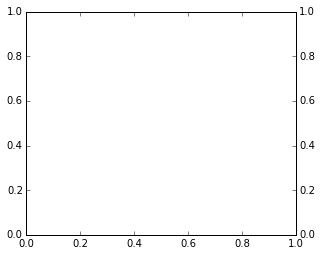

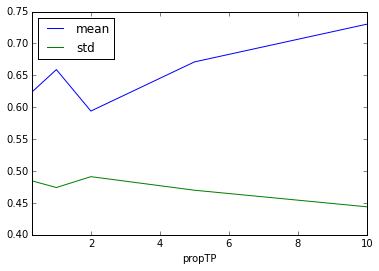

In [10]:
grouped = dfMulti.groupby('propTP')
stats = ['mean','std']
result = grouped['timed_out'].agg(stats)
print result
fig, ax = plt.subplots()
ax2 = ax.twinx()

fig.subplots_adjust(right=0.75)
result.plot()


#Other analysis 

#Select Problems :
For all mono problems finishing in an interval,
we compute the multi problems associated, and how many actually finish, in order to select problems with a certain order of difficulty.

chercher les problèmes qui finissent :

un problème est un sol et un .var, on veut que toutes ses variantes dans MONO tq distribution TP etc... finissent (nb Max) et que dans MULTI, toutes ses variantes finissent aussi (le max possible)

seletionner 2 faciles, 2 moyens et 2 difficiles (basé sur le pf et le % de TP etc... )

In [7]:
"""import collections
#def filterPb(dfOrig, df,timelimitInf,timelimitSup) :
dfOrig = dfFin
df = dfMulti
timelimitInf = 2.
timelimitSup = 8
'''
on veut des problèmes mono qui terminent dans un intervalle de temps 
et on veut ceux pour lesquels on a le plus de pb Multi qui finissent sans time out
'''
nbPbO=len(dfOrig.index)
nbPbD =len(df.index)

aggregate(df)#agg est une sorte d'id de problem
aggregate(dfOrig)

dfOrig = dfOrig[dfOrig['total time mn'] < timelimitSup]
dfOrig = dfOrig[dfOrig['total time mn'] > timelimitInf]
print 'on a ',len(dfOrig.index),' pb mono qui sont between'

distDict=collections.defaultdict(int)
distDictNtimeout=collections.defaultdict(int)
nbPnMultL= []
nbPbNitimeoutL = []
pbMultL= []
indL = []
#pour chaque pb MONO, on compte le nb de pb MULTI qui lui sont associés
for i in dfOrig.index :
    df['between'] = 0
    df.loc[df['indagg'].isin(dfOrig.loc[i]), 'between'] = 1
    nbPb = len(df[df['between']==1])
    pbNtimeoutdf = df[df['between']==1]
    nbNtimeout =len(pbNtimeoutdf[pbNtimeoutdf['timed_out']==0])
    pbMultL.append(df.loc[df['between']==1,['infile_path','infile','outfile','var','verbose','timeout','method','numagent','dist','csq','csq_mono','timed_out']])
    nbPnMultL.append(nbPb)
    nbPbNitimeoutL.append(nbNtimeout)
    distDict[nbPb] += 1
    distDictNtimeout[nbNtimeout] += 1
    indL.append(i)
print nbNtimeout
imax = np.argmax(np.array(nbPbNitimeoutL))
nMax = 120
indmax = np.argpartition(nbPbNitimeoutL, -nMax)[-nMax:] #pour prendre les indices des 10 plus grands

goodproblems = []
#ici on récupère ces problèmes interessants
for i in indmax :
    iDf = indL[i]
    pbNtimeout = pbMultL[i][pbMultL[i]['timed_out'] == 0]
    nbNtimeout = len(pbNtimeout)
    print '###############'
    print 'nbPb Mult', nbPnMultL[i]
    print 'nbNtimeout', nbNtimeout
    print 'ind i',i
    print nbPbNitimeoutL[i]
    print dfOrig.loc[iDf,['indagg','infile', 'method', 'var', 'csq', 'dist', 'numagent','total time mn']]
    print pbMultL[i]
    
    goodproblems.append(pbMultL[i])
    
print np.unique(np.array(nbPnMultL))
print sum(distDict.values())
print len(df.index)
print len(dfOrig.index)

goodproblems = pd.concat(goodproblems)
goodproblems.to_csv('base_problems_MULTI'+'.csv')


plt.bar(distDict.keys(), distDict.values(), 0.8, color='g')
plt.title('nb de Pb mono associes au prob multi')
plt.xlabel('nb de pb multi')
plt.ylabel('nb de pb mono')
plt.show()
plt.bar(distDictNtimeout.keys(), distDictNtimeout.values(), 0.8, color='g')
plt.title('nb de Pb multi sans time out associes aux pb mono')
plt.xlabel('nb de pb multi')
plt.ylabel('nb de pb mono')
plt.show()
#return distDict
#distDict = filterPb(dfFin, dfMulti_filt, 2.5,5.0 )
"""

"import collections\n#def filterPb(dfOrig, df,timelimitInf,timelimitSup) :\ndfOrig = dfFin\ndf = dfMulti\ntimelimitInf = 2.\ntimelimitSup = 8\n'''\non veut des probl\xc3\xa8mes mono qui terminent dans un intervalle de temps \net on veut ceux pour lesquels on a le plus de pb Multi qui finissent sans time out\n'''\nnbPbO=len(dfOrig.index)\nnbPbD =len(df.index)\n\naggregate(df)#agg est une sorte d'id de problem\naggregate(dfOrig)\n\ndfOrig = dfOrig[dfOrig['total time mn'] < timelimitSup]\ndfOrig = dfOrig[dfOrig['total time mn'] > timelimitInf]\nprint 'on a ',len(dfOrig.index),' pb mono qui sont between'\n\ndistDict=collections.defaultdict(int)\ndistDictNtimeout=collections.defaultdict(int)\nnbPnMultL= []\nnbPbNitimeoutL = []\npbMultL= []\nindL = []\n#pour chaque pb MONO, on compte le nb de pb MULTI qui lui sont associ\xc3\xa9s\nfor i in dfOrig.index :\n    df['between'] = 0\n    df.loc[df['indagg'].isin(dfOrig.loc[i]), 'between'] = 1\n    nbPb = len(df[df['between']==1])\n    pbNtimeoutdf

les pb mono qui ont beaucoup de pb multi qui finissent sont aussi ceux qui ont beaucoup de de pb multi associé, cela parait logique...

#interesting Multi problems
HERE we search to find all the multi problems which finish under the time taken by the mono problem !!

In [41]:
#indPbDist = [635,      ,      , ]
#indPbNonDist= [ 127,    138,   , ]
i = 635
iDf = indL[i]
dfOr = dfOrig.loc[iDf,['indagg','infile', 'method', 'var', 'csq', 'dist', 'numagent','total time mn']]
print dfOr
print pbMultL[i]

var = dfOr['var']
#on cherche le pb normal sans prédistribution associé
df = dfMulti[dfMulti['infile'].str.contains('TPnaiveshortdist_per10_s')]
df = df[df['var'] == var]
df=df[df['method'].str.contains('Async')]
#print df
print 'ILOC'
print df.iloc[0]
dfRes =pd.DataFrame()
dfRes = dfRes.append(df.iloc[0])
print 'DFDFDFDFDFDFDFDF', dfRes

#on cherche les pb multi prédistriubés associé mais pour plus d'agents
print 'fffffffffffffffff'
df = dfMulti[dfMulti['infile'].str.contains('TPuniformshortdist_per10_s')]
df = df[df['var'] == var]
#take only one method for instance where 
df=df[df['method'].str.contains('Async')]
print df
dfRes = pd.concat([dfRes, df])


print '####################'
i = 127
iDf = indL[i]
var = dfOr['var']
#on cherche le pb normal sans prédistribution associé
df = dfMulti[dfMulti['infile'].str.contains('TPnaiveshortdist_per10_s')]
df = df[df['var'] == var]
df=df[df['method'].str.contains('Async')]
#print df
print df.iloc[0]
dfRes = dfRes.append(df.iloc[0])



dfRes.to_csv('base_problems_MULTI.csv',index=False)

print 'ddddddddddd'
print dfRes

indagg           Problems/Bio/glucolysis_naiveEq4_TPuniformshor...
infile           glucolysis_naiveEq4_TPuniformshortdist_per5_se...
method                                              SOLAR-Inc-Carc
var                                                  _max-2_ld3--1
csq              Problems/Bio/glucolysis_naiveEq4_TPuniformshor...
dist                                                     _naiveEq4
numagent                                                         4
total time mn                                             2.266433
Name: 1709, dtype: object
       infile_path                                             infile  \
254  Problems/Bio/  glucolysis_naiveEq4_TPuniformshortdist_per5_se...   
255  Problems/Bio/  glucolysis_naiveEq4_TPuniformshortdist_per5_se...   
256  Problems/Bio/  glucolysis_naiveEq4_TPuniformshortdist_per5_se...   

     outfile            var  verbose  timeout         method  numagent  \
254      NaN  _max-2_ld3--1      NaN      NaN  DICF-PB-Async         4 